# # Set 3 — Q8
**Task:** Implement **split-and-merge** segmentation (quad-tree). Segment the image using different
minimum dimensions of the quad-tree regions.

In [1]:
# %%
# --- Imports & Config ---
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# === User: set your image path here ===
img_path = "../image.jpg"   

# Parameters (feel free to tweak)
MIN_DIMS = [64, 32, 16]  # different minimum region sizes to demonstrate effect
STD_THRESH = 6.0         # homogeneity threshold (pixel intensity std-dev); lower = more splitting
MERGE_TOL  = 8.0         # merge neighbouring leaves if |mean1 - mean2| <= MERGE_TOL (0..255 scale)

out_dir = Path("./outputs_q8")
out_dir.mkdir(parents=True, exist_ok=True)

def imshow(ax, img, title="", cmap=None):
    ax.imshow(img if cmap is None else img, cmap=cmap)
    ax.set_title(title); ax.axis("off")

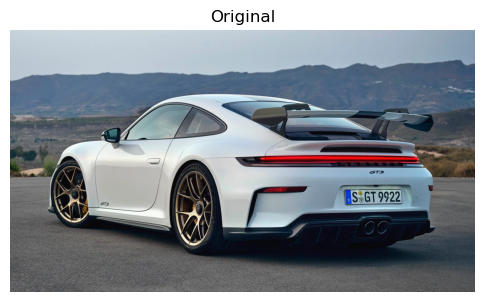

In [2]:
# %%
# --- Load / prepare grayscale image ---
img_bgr = cv2.imread(img_path, cv2.IMREAD_COLOR)
if img_bgr is None:
    # Fallback: synthetic image with blocks & gradients
    h, w = 384, 512
    y = np.linspace(0, 1, h)[:, None]
    x = np.linspace(0, 1, w)[None, :]
    grad = (0.5*y + 0.5*x) * 255
    blocks = np.zeros((h, w), np.uint8)
    cv2.rectangle(blocks, (40, 40), (200, 170), 200, -1)
    cv2.circle(blocks, (360, 120), 60, 80, -1)
    cv2.rectangle(blocks, (260, 220), (470, 360), 160, -1)
    gray = np.clip(0.6*grad + 0.4*blocks, 0, 255).astype(np.uint8)
    img_rgb = cv2.cvtColor(gray, cv2.COLOR_GRAY2RGB)
else:
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)

fig, ax = plt.subplots(1,1, figsize=(6,5))
imshow(ax, img_rgb, "Original")
plt.show()

In [3]:
# %%
# --- Quadtree Split ---
from collections import namedtuple, deque

Node = namedtuple("Node", ["x", "y", "w", "h", "mean", "std"])

def compute_stats(patch):
    m = float(patch.mean())
    s = float(patch.std())
    return m, s

def quadtree_split(img, min_dim=32, std_thresh=6.0):
    # Split into leaf nodes; each leaf has (x,y,w,h,mean,std).
    h, w = img.shape
    leaves = []
    q = deque()
    m, s = compute_stats(img)
    q.append(Node(0, 0, w, h, m, s))
    while q:
        nd = q.popleft()
        x, y, w, h = nd.x, nd.y, nd.w, nd.h

        if (nd.std <= std_thresh) or (w < 2*min_dim and h < 2*min_dim) or (w <= min_dim or h <= min_dim):
            leaves.append(nd)
            continue

        # split into 4
        w2 = w // 2
        h2 = h // 2
        xs = [x, x + w2]
        ys = [y, y + h2]
        ws = [w2, w - w2]
        hs = [h2, h - h2]

        for jj in range(2):
            for ii in range(2):
                xx = xs[ii]; yy = ys[jj]; ww = ws[ii]; hh = hs[jj]
                patch = img[yy:yy+hh, xx:xx+ww]
                m, s = compute_stats(patch)
                q.append(Node(xx, yy, ww, hh, m, s))
    return leaves

In [4]:
# %%
# --- Merge Adjacent Leaves with Union-Find ---
class UnionFind:
    def __init__(self, n):
        self.p = list(range(n))
        self.r = [0]*n
    def find(self, a):
        while self.p[a] != a:
            self.p[a] = self.p[self.p[a]]
            a = self.p[a]
        return a
    def union(self, a, b):
        ra, rb = self.find(a), self.find(b)
        if ra == rb: return False
        if self.r[ra] < self.r[rb]:
            self.p[ra] = rb
        elif self.r[ra] > self.r[rb]:
            self.p[rb] = ra
        else:
            self.p[rb] = ra
            self.r[ra] += 1
        return True

def split_and_merge(gray, min_dim, std_thresh, merge_tol):
    leaves = quadtree_split(gray, min_dim=min_dim, std_thresh=std_thresh)

    # Map every pixel to its leaf-id and store leaf means
    H, W = gray.shape
    leaf_map = -np.ones((H, W), dtype=np.int32)
    means = []
    for i, nd in enumerate(leaves):
        means.append(nd.mean)
        leaf_map[nd.y:nd.y+nd.h, nd.x:nd.x+nd.w] = i
    means = np.array(means, dtype=np.float32)

    # Union neighbouring leaves that touch and have similar means
    uf = UnionFind(len(leaves))
    # Scan right/down neighbours on pixel grid
    for y in range(H):
        for x in range(W-1):
            a = leaf_map[y, x]; b = leaf_map[y, x+1]
            if a != b and abs(means[a] - means[b]) <= merge_tol:
                uf.union(a, b)
    for y in range(H-1):
        for x in range(W):
            a = leaf_map[y, x]; b = leaf_map[y+1, x]
            if a != b and abs(means[a] - means[b]) <= merge_tol:
                uf.union(a, b)

    # Compress ids and build final label image
    root = np.array([uf.find(i) for i in range(len(leaves))], dtype=np.int32)
    # remap roots to 1..K
    uniq = np.unique(root)
    remap = {r:i+1 for i, r in enumerate(uniq)}
    labels = np.vectorize(lambda lid: remap[root[lid]])(leaf_map)

    # Gray mean image for visualization
    mean_img = np.zeros_like(gray, dtype=np.float32)
    for i, nd in enumerate(leaves):
        mean_img[nd.y:nd.y+nd.h, nd.x:nd.x+nd.w] = means[i]
    return labels.astype(np.int32), mean_img, leaves

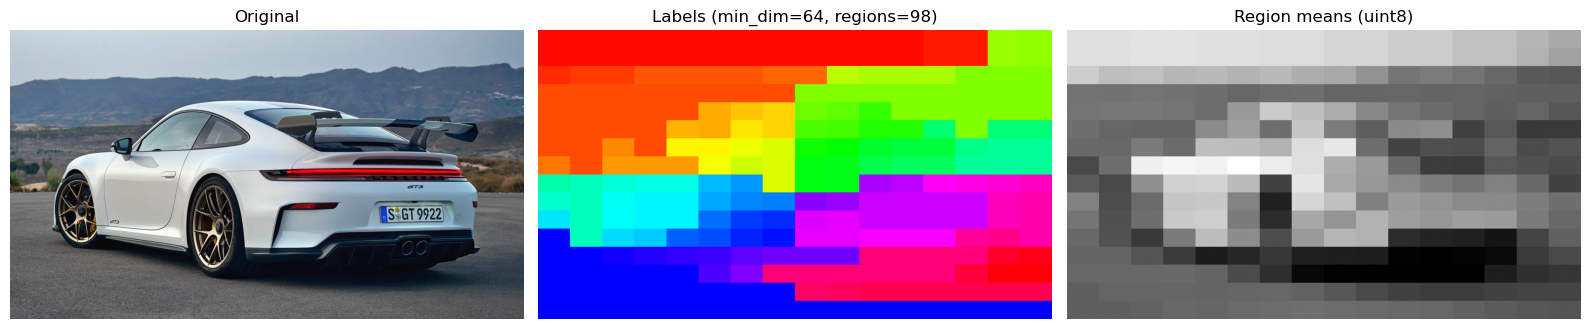

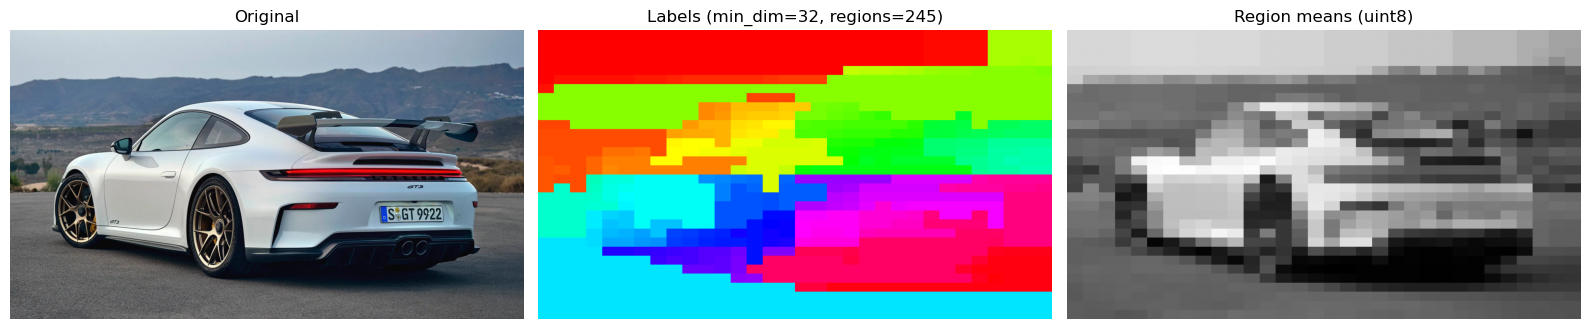

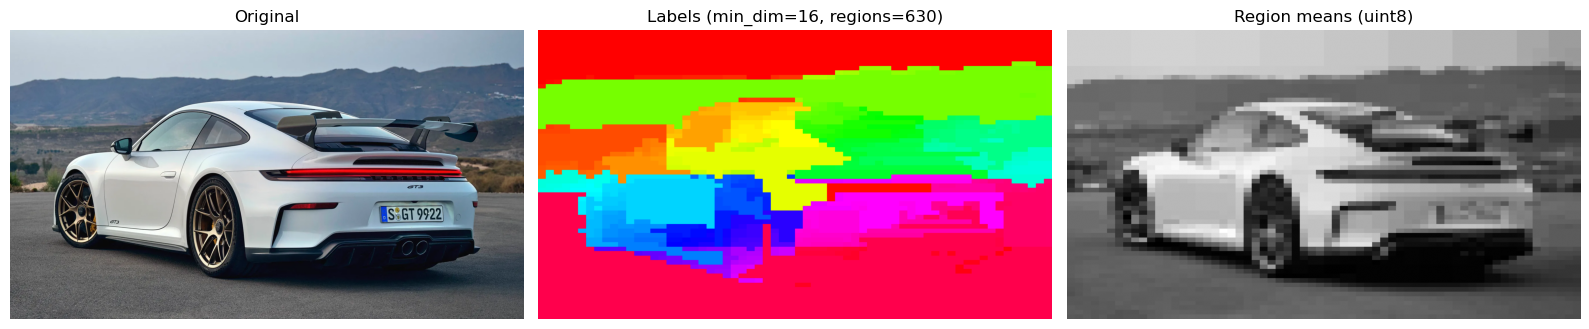

Saved outputs to: D:\git\Image and Video Processing\Lab_3\QUESTION8\outputs_q8


In [5]:
# %%
# --- Run for multiple min_dim values and visualize ---
results = []
for md in MIN_DIMS:
    labels, mean_img, leaves = split_and_merge(gray, md, STD_THRESH, MERGE_TOL)
    results.append((md, labels, mean_img, leaves))

    # Colorize labels
    K = labels.max()
    hue = (labels.astype(np.float32) / max(1,K)) * 179
    hsv = np.dstack([hue.astype(np.uint8), np.full_like(hue, 255, np.uint8), (labels>0).astype(np.uint8)*255])
    color_labels = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)

    # Contour overlay
    contours, _ = cv2.findContours((labels>0).astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    overlay = img_rgb.copy()
    cv2.drawContours(overlay, contours, -1, (255,0,0), 2)

    fig, axs = plt.subplots(1, 3, figsize=(16,5))
    imshow(axs[0], img_rgb, "Original")
    imshow(axs[1], color_labels, f"Labels (min_dim={md}, regions={K})")
    imshow(axs[2], mean_img.astype(np.uint8), "Region means (uint8)", cmap="gray")
    plt.tight_layout(); plt.show()

    cv2.imwrite(str(out_dir / f"q8_labels_min{md}.png"), cv2.cvtColor(color_labels, cv2.COLOR_RGB2BGR))
    cv2.imwrite(str(out_dir / f"q8_overlay_min{md}.png"), cv2.cvtColor(overlay, cv2.COLOR_RGB2BGR))
    cv2.imwrite(str(out_dir / f"q8_mean_min{md}.png"), mean_img.astype(np.uint8))

print("Saved outputs to:", out_dir.resolve())